# Think Bayes: Chapter 9

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from itertools import product
from IPython.display import display
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb

'Done'

'Done'

## Improving Reading Ability

From DASL(http://lib.stat.cmu.edu/DASL/Stories/ImprovingReadingAbility.html)

> An educator conducted an experiment to test whether new directed reading activities in the classroom will help elementary school pupils improve some aspects of their reading ability. She arranged for a third grade class of 21 students to follow these activities for an 8-week period. A control classroom of 23 third graders followed the same curriculum without the activities. At the end of the 8 weeks, all students took a Degree of Reading Power (DRP) test, which measures the aspects of reading ability that the treatment is designed to improve.

> Summary statistics on the two groups of children show that the average score of the treatment class was almost ten points higher than the average of the control class. A two-sample t-test is appropriate for testing whether this difference is statistically significant. The t-statistic is 2.31, which is significant at the .05 level.



I'll use Pandas to load the data into a DataFrame.

In [2]:
df = pd.read_csv('ThinkBayes2/code/drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


And use `groupby` to compute the means for the two groups.

In [3]:
grouped = df.groupby('Treatment')
for name, group in grouped:
    print(name, group.Response.mean())

Control 41.52173913043478
Treated 51.476190476190474


The `Normal` class provides a `Likelihood` function that computes the likelihood of a sample from a normal distribution.

In [4]:
class Normal(mtb.PMF, mtb.Joint):
    
    def likelihood(self, data, hypo):
        """
        data: sequence of test scores
        hypo: mu, sigma
        """
        mu, sigma = hypo
        likes = stats.norm.pdf(data, mu, sigma)
        return np.prod(likes)

The prior distributions for `mu` and `sigma` are uniform.

In [5]:
mus = np.linspace(20, 80, 101)
sigmas = np.linspace(5, 30, 101)

I use `itertools.product` to enumerate all pairs of `mu` and `sigma`.

In [6]:
control = Normal(list(product(mus, sigmas)))
data = grouped.get_group('Control').Response
control.update(data)

(20.0, 5.0)      5.677808e-135
(20.0, 5.25)     1.242201e-121
(20.0, 5.5)      4.116529e-110
(20.0, 5.75)     4.231692e-100
(20.0, 6.0)       2.386865e-91
(20.0, 6.25)      1.168170e-83
(20.0, 6.5)       7.193649e-77
(20.0, 6.75)      7.553357e-71
(20.0, 7.0)       1.737170e-65
(20.0, 7.25)      1.077279e-60
(20.0, 7.5)       2.142988e-56
(20.0, 7.75)      1.582419e-52
(20.0, 8.0)       4.907312e-49
(20.0, 8.25)      7.098356e-46
(20.0, 8.5)       5.238405e-43
(20.0, 8.75)      2.130049e-40
(20.0, 9.0)       5.099727e-38
(20.0, 9.25)      7.614183e-36
(20.0, 9.5)       7.452619e-34
(20.0, 9.75)      4.994931e-32
(20.0, 10.0)      2.381535e-30
(20.0, 10.25)     8.353166e-29
(20.0, 10.5)      2.219956e-27
(20.0, 10.75)     4.588615e-26
(20.0, 11.0)      7.549546e-25
(20.0, 11.25)     1.009263e-23
(20.0, 11.5)      1.116613e-22
(20.0, 11.75)     1.039294e-21
(20.0, 12.0)      8.258331e-21
(20.0, 12.25)     5.676645e-20
                     ...      
(80.0, 22.75)     2.221659e-18
(80.0, 2

After the update, we can plot the probability of each `mu`-`sigma` pair as a contour plot.

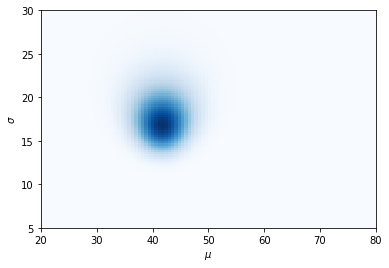

In [7]:
X, Y = np.meshgrid(mus, sigmas)

func = np.vectorize(lambda x, y: control[(x, y)])
Z = func(X, Y)

plt.pcolormesh(X, Y, Z, cmap=matplotlib.cm.Blues)
plt.ylabel('$\sigma$')
plt.xlabel('$\mu$')
plt.show()

And then we can extract the marginal distribution of `mu`, which is the distribution of $\mu$ values across all possible $\sigma$ values.

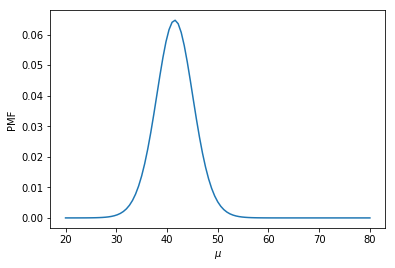

In [8]:
mrg_mu = control.marginal(0)
mrg_mu.plot()
plt.ylabel('PMF')
plt.xlabel('$\mu$')
plt.show()

And the marginal distribution of `sigma`

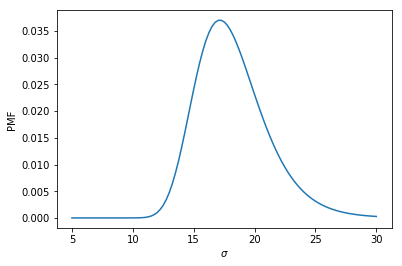

In [9]:
mrg_sigma = control.marginal(1)
mrg_sigma.plot()
plt.ylabel('PMF')
plt.xlabel('$\sigma$')
plt.show()

**Exercise:** Run this analysis again for the ~~control~~ TREATED group.  What is the distribution of the difference between the groups?  What is the probability that the average "reading power" for the treatment group is higher?  What is the probability that the variance of the treatment group is higher?

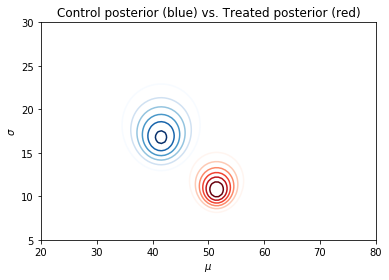

In [10]:
mus = np.linspace(20, 80, 101)
sigmas = np.linspace(5, 30, 101)

probs = np.ones(len(mus) * len(sigmas))

control = Normal(product(mus, sigmas), probs)
control.update(grouped.get_group('Control').Response)
treated = Normal(product(mus, sigmas), probs)
treated.update(grouped.get_group('Treated').Response)


X, Y = np.meshgrid(mus, sigmas)
func = np.vectorize(lambda x, y: control[(x, y)])
Zc = func(X, Y)
func = np.vectorize(lambda x, y: treated[(x, y)])
Zt = func(X, Y)

plt.contour(X, Y, Zc, cmap=matplotlib.cm.Blues, label='Control')
plt.contour(X, Y, Zt, cmap=matplotlib.cm.Reds, label='Treated')
plt.ylabel('$\sigma$')
plt.xlabel('$\mu$')
plt.title('Control posterior (blue) vs. Treated posterior (red)')
plt.show()

The treated group has a higher mean and a lower variance.

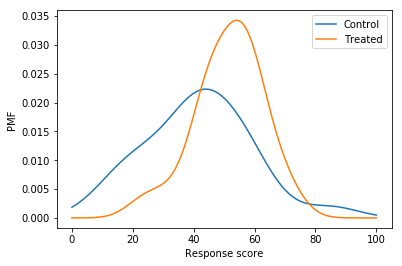

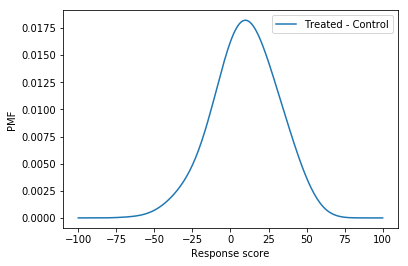

In [11]:
# What is the distribution of difference between the two groups?
hypos = np.arange(101)
resp_control = mtb.PMF.from_kde(grouped.get_group('Control').Response, hypos)
resp_treated = mtb.PMF.from_kde(grouped.get_group('Treated').Response, hypos)
resp_control.plot(label='Control')
resp_treated.plot(label='Treated')
plt.xlabel('Response score')
plt.ylabel('PMF')
plt.legend()
plt.show()

diff = resp_treated - resp_control
diff.plot(label='Treated - Control')
plt.xlabel('Response score')
plt.ylabel('PMF')
plt.legend()
plt.show()

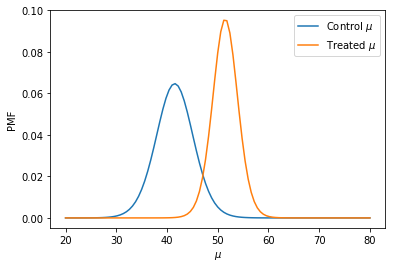

$P(Treated \mu > Control \mu) = 0.9805$


In [12]:
# What is the probability that the average "reading power" for the treatment group is higher?  
control_mrg_mu = control.marginal(0)
treated_mrg_mu = treated.marginal(0)
control_mrg_mu.plot(label='Control $\mu$')
treated_mrg_mu.plot(label='Treated $\mu$')
plt.xlabel('$\mu$')
plt.ylabel('PMF')
plt.legend()
plt.show()

print('$P(Treated \mu > Control \mu) = %.4lf$' % (treated_mrg_mu > control_mrg_mu))

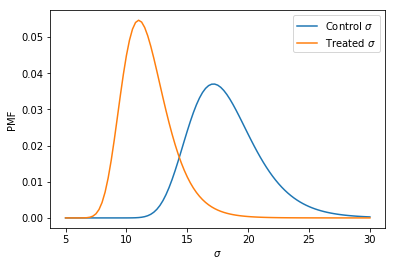

P(Treated \sigma > Control \sigma) = 0.0269


In [13]:
# What is the probability that the variance of the treatment group is higher?
control_mrg_sigma = control.marginal(1)
treated_mrg_sigma = treated.marginal(1)
control_mrg_sigma.plot(label='Control $\sigma$')
treated_mrg_sigma.plot(label='Treated $\sigma$')
plt.xlabel('$\sigma$')
plt.ylabel('PMF')
plt.legend()
plt.show()

print('P(Treated \sigma > Control \sigma) = %.4lf' % (treated_mrg_sigma > control_mrg_sigma))

It looks like there is a high probability that the mean of
the treatment group is higher, and the most likely size of
the effect is 9-10 points.

It looks like the variance of the treated group is substantially
smaller, which suggests that the treatment might be helping
low scorers more than high scorers.

## Paintball

Suppose you are playing paintball in an indoor arena 30 feet
wide and 50 feet long.  You are standing near one of the 30 foot
walls, and you suspect that one of your opponents has taken cover
nearby.  Along the wall, you see several paint spatters, all the same
color, that you think your opponent fired recently.

The spatters are at 15, 16, 18, and 21 feet, measured from the
lower-left corner of the room.  Based on these data, where do you
think your opponent is hiding?

Here's the Suite that does the update.  It uses `MakeLocationPmf`,
defined below.

An ASCII diagram of alpha, beta, and theta.

```
|-----------------------|
beta ---------*         |
|    theta -> .\        |  
|             . \       |
|             .  \      |
|             .   \     |
|             .    \    |
|-----alpha---------X---| 
```

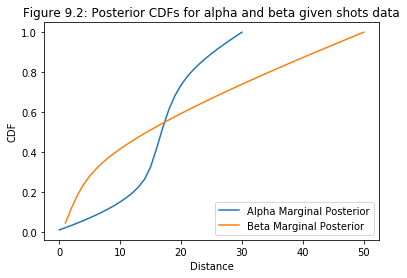

Alpha CI (14, 21)
Beta CI (5, 31)


In [14]:
class Paintball(mtb.PMF, mtb.Joint):
    
    def __init__(self, alphas, betas, X):
        
        # PMF over possible locations in the room with uniform prior.
        hypos = list(product(alphas, betas))
        probs = np.ones(len(hypos))
        super().__init__(hypos, probs)
        
        # Used later.
        self.X = X
        
    def _strafing_speed(self, alpha, beta, locations):
        """Computes the strafing speed as defined on page 100.
        
        Vectorized version of Downey's function."""
        thetas = np.arctan2(locations - alpha, locations * 0 + beta)
        return beta / np.cos(thetas)**2
        
    def X_pmf(self, alpha, beta):
        """Compute PMF over X values given specific (alpha, beta) locations."""
        hypos = self.X
        probs = 1. / self._strafing_speed(alpha, beta, hypos)
        return mtb.PMF(hypos, probs)
    
    def likelihood(self, data, hypo):
        """P(X location of a shot | (alpha, beta) player position)"""
        x = data
        alpha, beta = hypo
        return self.X_pmf(alpha, beta)[x]

A = np.arange(0, 31)
B = np.arange(1, 51)
X = np.arange(0, 31)
    
pb = Paintball(A, B, X)

for x in [15, 16, 18, 21]:
    pb.update(x)

mrg_alpha = pb.marginal(0).to_cdf()
mrg_beta = pb.marginal(1).to_cdf()
mrg_alpha.plot(label='Alpha Marginal Posterior')
mrg_beta.plot(label='Beta Marginal Posterior')
plt.legend()
plt.ylabel('CDF')
plt.xlabel('Distance')
plt.title('Figure 9.2: Posterior CDFs for alpha and beta given shots data')
plt.show()

print('Alpha CI (%d, %d)' % tuple(mrg_alpha.interval([25, 75])))
print('Beta CI (%d, %d)' % tuple(mrg_beta.interval([25, 75])))

To visualize the joint posterior, I take slices for a few values of `beta` and plot the conditional distributions of `alpha`.  If the shooter is close to the wall, we can be somewhat confident of his position.  The farther away he is, the less certain we are.

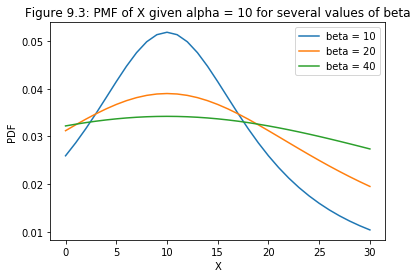

In [15]:
a = 10
B_ = [10, 20, 40]

for b in B_:
    pmf = pb.X_pmf(a, b)
    pmf.plot(label='beta = %d' % b)

plt.title('Figure 9.3: PMF of X given alpha = %d for several values of beta' % a)
plt.ylabel('PDF')
plt.xlabel('X')
plt.legend()
plt.show()

Here are the marginal posterior distributions for `alpha` and `beta`.

To visualize the joint posterior, I take slices for a few values of `beta` and plot the conditional distributions of `alpha`.  If the shooter is close to the wall, we can be somewhat confident of his position.  The farther away he is, the less certain we are.

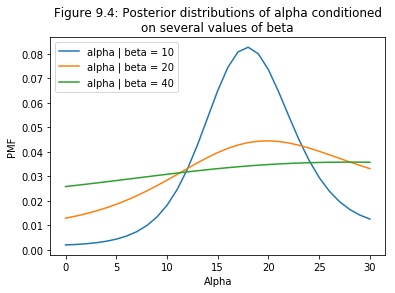

In [16]:
B_ = [10, 20, 40]

for beta in B_:
    cond = pb.conditional(0, 1, beta)
    cond.plot(label='alpha | beta = %d' % beta)
    
plt.title('Figure 9.4: Posterior distributions of alpha conditioned\non several values of beta')
plt.xlabel('Alpha')
plt.ylabel('PMF')
plt.legend()
plt.show()

Another way to visualize the posterio distribution: a pseudocolor plot of probability as a function of `alpha` and `beta`.

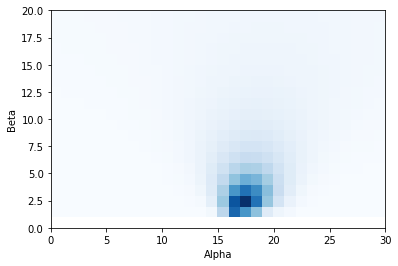

In [17]:
plt.pcolormesh(*mtb.Joint.contour_args(pb), cmap=matplotlib.cm.Blues,)
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.ylim(0, 20)
plt.show()

Here's another visualization that shows posterior credible regions.

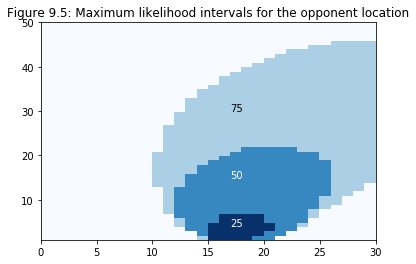

In [18]:
mlpmf = pb.mlintervals([0.25, 0.5, 0.75])
X, Y, Z = mtb.Joint.contour_args(mlpmf)
plt.pcolormesh(X, Y, Z, cmap=matplotlib.cm.Blues)
plt.text(17, 4, '25', color='white')
plt.text(17, 15, '50', color='white')
plt.text(17, 30, '75')
plt.title('Figure 9.5: Maximum likelihood intervals for the opponent location')
plt.show()

**Exercise:** From [John D. Cook](http://www.johndcook.com/blog/2010/07/13/lincoln-index/)

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find.  The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs.  What is the Bayesian estimate of the number of errors based on this data?

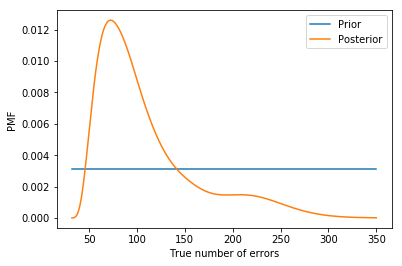

In [19]:
from scipy.special import binom as choose

def binom(k, n, p):
    return p**k * (1-p)**(n-k)

class CodeErrors(mtb.PMF, mtb.Joint):
    
    def likelihood(self, data, hypo):
        k1, k2, c = data
        n, t1_acc, t2_acc = hypo
        like = choose(n, k1)            # No. ways for tester 1 to report k1 errors from n total errors..
        like *= choose(k1, c)           # No. ways for tester 2 to match tester 1 on c errors.
        like *= choose(n - k1, k2 - c)  # No. ways for tester 2 to report her remaining errors.
        like *= binom(k1, n, t1_acc)    # Probability that tester 1's errors were actual errors.
        like *= binom(k2, n, t2_acc)    # Probability that tester 2's errors were actual errors.
        return like
    
N = np.arange(32, 351)           # Possible numbers of errors.
A = np.linspace(0, 1, 14)        # Possible tester accuracies.
hypos = list(product(N, A, A))   # PMF over 3-dimensional hypotheses.

ce = CodeErrors(hypos)
ce.marginal(0).plot(label='Prior')

ce.update((20, 15, 3))           # Update, tester 1 finds 20 errors, tester 2 15, 3 in common.

ce.marginal(0).plot(label='Posterior')
plt.ylabel('PMF')
plt.xlabel('True number of errors')
plt.legend()
plt.show()

**Exercise:** The GPS problem.  According to [Wikipedia]()

￼
> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

CPU times: user 312 ms, sys: 4 ms, total: 316 ms
Wall time: 316 ms


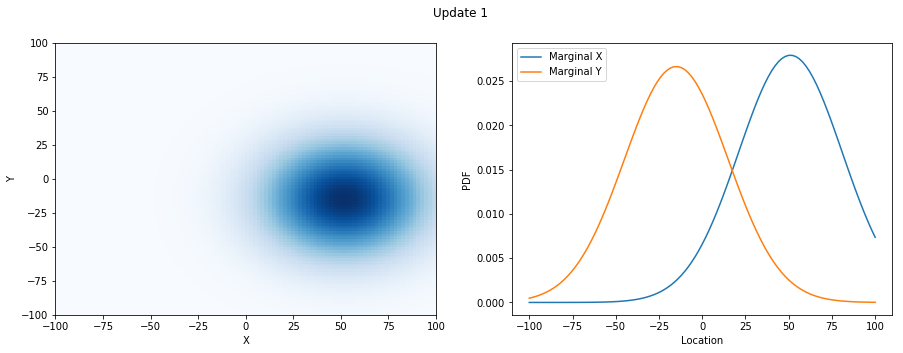

CPU times: user 336 ms, sys: 56 ms, total: 392 ms
Wall time: 330 ms


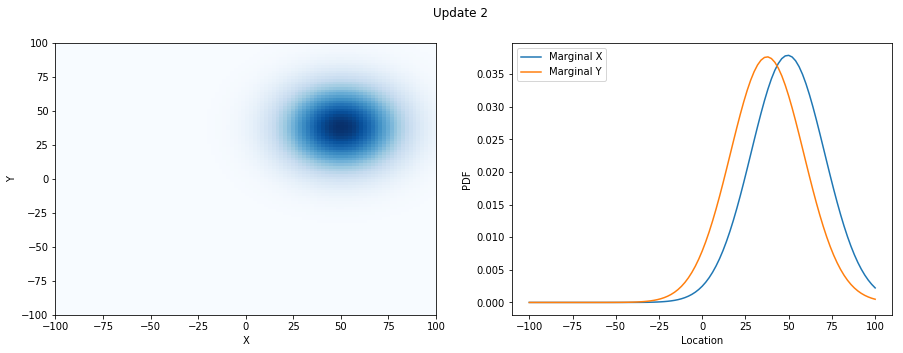

CPU times: user 316 ms, sys: 60 ms, total: 376 ms
Wall time: 315 ms
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 317 ms
CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 318 ms
CPU times: user 312 ms, sys: 4 ms, total: 316 ms
Wall time: 315 ms
CPU times: user 324 ms, sys: 0 ns, total: 324 ms
Wall time: 318 ms
CPU times: user 316 ms, sys: 4 ms, total: 320 ms
Wall time: 317 ms
CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 315 ms
CPU times: user 312 ms, sys: 4 ms, total: 316 ms
Wall time: 315 ms


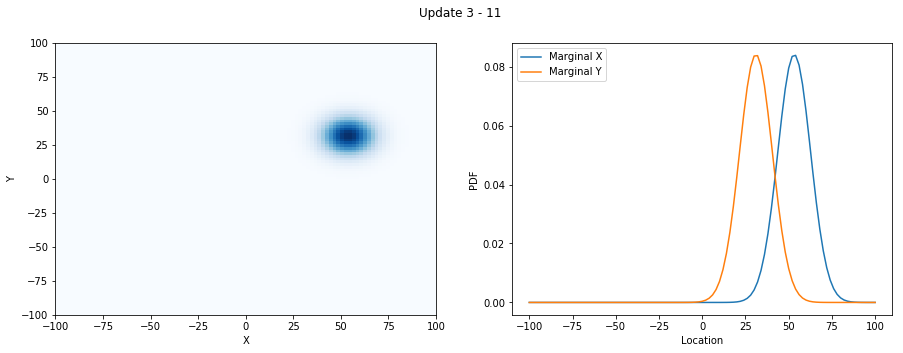

In [20]:
class GPS(mtb.PMF, mtb.Joint):
    
    def __init__(self, HX, HY):
        hypos = list(product(HX, HY))
        super().__init__(hypos)
        
        self._X = [(hx, stats.norm(hx, 30)) for hx in HX]
        self._Y = [(hy, stats.norm(hy, 30)) for hy in HX]
    
    def update(self, data):
        """Combination of update() and likelihood() optimized to be much faster than the typical setup.
        
        P(data | hypothesis)
        = P(reported location | hypothesized location) 
        = P((rx, ry) | (hx, hy))
        = N(hx, 30).pdf(rx) * N(hy, 30).pdf(ry)
        
        I optimize by making sure to only compute each hx and hy likelihood once."""
        
        rx, ry = data
        LY = dict()
        for hx, rvhx in self._X:
            lx = rvhx.pdf(rx)
            for hy, rvhy in self._Y:
                if hy not in LY:
                    LY[hy] = rvhy.pdf(ry)
                ly = LY[hy]
                self[(hx, hy)] *= lx * ly
        return self.normalize()
    
    def plot(self, title='GPS'):
        X, Y, Z = mtb.Joint.contour_args(self)
        mx, my = self.marginal(0), self.marginal(1)
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
        ax1.pcolormesh(X, Y, Z, cmap=matplotlib.cm.Blues)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax2.plot(mx.hypos, mx.probs, label='Marginal X')
        ax2.plot(my.hypos, my.probs, label='Marginal Y')
        ax2.set_xlabel('Location')
        ax2.set_ylabel('PDF')
        ax2.legend()
        plt.suptitle(title)
        plt.show()
        
# 50 x 40 meter field.
HX = np.linspace(-100, 100, 101)
HY = np.linspace(-100, 100, 101)

gps = GPS(HX, HY)

%time gps.update((51, -15))
gps.plot(title='Update 1')

%time gps.update((48, 90))
gps.plot(title='Update 2')

locs = [(11.903060613102866, 19.79168669735705),
             (77.10743601503178, 39.87062906535289),
             (80.16596823095534, -12.797927542984425),
             (67.38157493119053, 83.52841028148538),
             (89.43965206875271, 20.52141889230797),
             (58.794021026248245, 30.23054016065644),
             (2.5844401241265302, 51.012041625783766),
             (45.58108994142448, 3.5718287379754585)]

for x, y in locs:
    %time gps.update((x, y))
    
gps.plot(title='Update 3 - %d' % (3 + len(locs)))

In [21]:
'Maximum a-posteriori location = %s with probability %.4lf' % gps.MAP()

'Maximum a-posteriori location = (54.0, 32.0) with probability 0.0070'

**Exercise:** [The Flea Beetle problem from DASL](http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)

Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema


Suggestions: 

1. Plot CDFs for the width and angle data, broken down by species, to get a visual sense of whether the normal distribution is a good model.

2. Use the data to estimate the mean and standard deviation for each variable, broken down by species.

3. Given a joint posterior distribution for `mu` and `sigma`, what is the likelihood of a given datum?

4. Write a function that takes a measured width and angle and returns a posterior PMF of species.

5. Use the function to classify each of the specimens in the table and see how many you get right.


In [22]:
df = pd.read_csv('ThinkBayes2/code/flea_beetles.csv', delimiter='\t')
grouped = df.groupby('Species')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


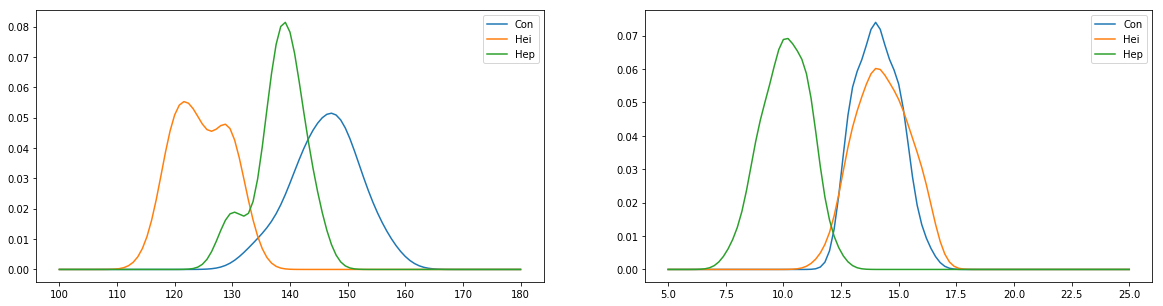

In [23]:
# Plot CDFs for the width and angle data, broken down by species, 
# to get a visual sense of whether the normal distribution is a good model.

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 5))

for species, group in grouped:
    x = mtb.PMF.from_kde(group.Width, np.linspace(100, 180, 101))
    ax1.plot(x.hypos, x.probs, label=species)
    x = mtb.PMF.from_kde(group.Angle, np.linspace(5, 25, 101))
    ax2.plot(x.hypos, x.probs, label=species)
    
ax1.legend()
ax2.legend()
plt.show()

In [24]:
# Use the data to estimate the mean and standard deviation for each variable, broken down by species.
for species, group in grouped:
    print('%s width ~ N(mu=%.2lf, sigma=%.2lf)' % (species, group.Width.mean(), group.Width.std()))
    print('%s angle ~ N(mu=%.2lf, sigma=%.2lf)' % (species, group.Angle.mean(), group.Angle.std()))

Con width ~ N(mu=146.19, sigma=5.63)
Con angle ~ N(mu=14.10, sigma=0.89)
Hei width ~ N(mu=124.65, sigma=4.62)
Hei angle ~ N(mu=14.29, sigma=1.10)
Hep width ~ N(mu=138.27, sigma=4.14)
Hep angle ~ N(mu=10.09, sigma=0.97)


In [25]:
# Given a joint posterior distribution for mu and sigma, what is the likelihood of a given datum?
# Write a function that takes a measured width and angle and returns a posterior PMF of species.

class BeetleClassifier(object):
    
    def __init__(self, hypos):
        self.hypos = hypos
        self.hypo2rv = dict()
        
    def fit(self, df_grouped, features):
        """Compute a distribution via Gaussian KDE for each feature
        and store it in the self.hypo2rv dict.
        
        e.g. self.hypo2rv['Con']['Width'] is the parameterized random variable
        for the Con class' widths."""
    
        for hypo in hypos:
            group = df_grouped.get_group(hypo)
            self.hypo2rv[hypo] = dict()
            for feat in features:
                self.hypo2rv[hypo][feat] = stats.gaussian_kde(group[feat])
    
    def predict(self, df):
        """Compute the likelihood of each class given the data using the 
        previously computed parameterized random variables.
        
        e.g. the likelihood of class Con given width "w" and angle "a" is
        the density of w for Con's width random variable multiplied by the
        density of a for Con's angle random variable."""
        
        preds = np.ones((len(df), len(self.hypos)))
        for i, hypo in enumerate(self.hypos):
            for feat, rv in self.hypo2rv[hypo].items():
                preds[:, i] *= rv.pdf(df[feat])
        return preds / preds.sum(axis=1, keepdims=True)

hypos = sorted(df.Species.unique())
ytrue = np.zeros((len(df), len(hypos)))
for i, x in enumerate(df.Species):
    ytrue[i, hypos.index(x)] = 1
    
clf = BeetleClassifier(hypos)
%time clf.fit(df.groupby('Species'), ['Width', 'Angle'])
%time ypred = clf.predict(df)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.52 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.01 ms


In [26]:
acc = sum(ypred.argmax(axis=1) == ytrue.argmax(axis=1)) / len(ytrue)
print('Accuracy = %.3lf (%d of %d correct)' % (acc, len(ytrue) * acc, len(ytrue)))

Accuracy = 0.986 (73 of 74 correct)


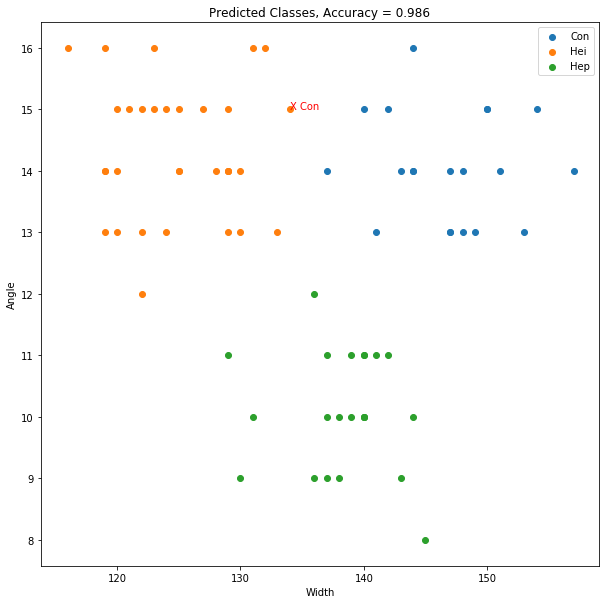

In [27]:
df['Species_pred'] = [hypos[i] for i in ypred.argmax(axis=1)]

plt.figure(figsize=(10, 10))

for species, group in df.groupby('Species_pred'):
    plt.scatter(group.Width, group.Angle, label=species)
    
for i, row in df.iterrows():
    if row.Species != row.Species_pred:
        plt.text(row.Width, row.Angle, 'X %s' % row.Species, color='red')
        
plt.title('Predicted Classes, Accuracy = %.3lf' % acc)
plt.legend()
plt.xlabel('Width')
plt.ylabel('Angle')
plt.show()

In [28]:
'Done'

'Done'